# Predictions with 30% for training, 30% for validation, and 70% for testing

In [1]:
# Load the necessary libraries for the project
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import os
import warnings
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from netCDF4 import Dataset, num2date
import geopandas as gpd
import cv2
from datetime import datetime, timedelta

In [2]:
# Cargar los datos
data = pd.read_csv(r"C:\Users\alezavala\Downloads\capstone_final.csv")
# Mostrar las primeras filas para inspección
data.head(10000000)

,time,latitude,longitude,tmax
0,0,-32.0,-71.50,21.574158
1,0,-32.0,-71.25,26.105469
2,0,-32.0,-71.00,27.796630
3,0,-32.0,-70.75,23.897919
4,0,-32.0,-70.50,15.834045
...,...,...,...,...
6852386,26662,-40.0,-72.75,24.436981
6852387,26662,-40.0,-72.50,22.860779
6852388,26662,-40.0,-72.25,21.769104
6852389,26662,-40.0,-72.00,21.935333


In [3]:
#Pivotear la tabla 
# Cada fila representará una estación y cada columna un día diferente
y = data.pivot_table(index=['latitude', 'longitude'], columns='time', values='tmax')

# Ordenar el marco de datos resultante por latitud y longitud
y = y.sort_index()

# Preparar los datos de entrada X
# Seleccionamos las columnas de latitud y longitud y eliminamos los duplicados
X = y.index.to_frame(index=False)

# Dividir los datos en conjuntos de entrenamiento y prueba
# Dividiremos los datos usando una proporción de 70% de testeo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)

# Ahora X_train y X_test contienen las coordenadas de las estaciones
# y_train y y_test contienen las temperaturas para cada día en las estaciones correspondientes

# Mostraremos la forma de los marcos de datos resultantes para confirmar que todo está como se espera
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((77, 2), (180, 2), (77, 26663), (180, 26663))

## Descomposición SVD de los datos de entrenamiento
Deseamos descomponer los valores objetivo de entrenamiento utilizando una SVD (EOF). De esta manera, obtendremos tres objetos: un conjunto de series temporales de componentes principales, un conjunto de autovalores y un conjunto de coeficientes espaciales. Además, necesitamos almacenar la media temporal de los datos brutos. Como restaremos esta cantidad antes de realizar la SVD, la necesitaremos más adelante para reconstruir la señal original. La descomposición se realiza según Wikle, 2019.

In [4]:
Z = tf.constant(y_train.values, dtype=tf.float32) 
print('Matrix Z: \n{}\n'.format(Z))

time_mean = tf.reduce_mean(Z, 0)
nS = tf.constant(Z.shape[0], dtype =tf.float32)
time_mean = tf.reshape(tf.tile(time_mean, [nS]), [nS, time_mean.shape[0]])

Ztime_detrend = Z - time_mean
Ztilde = 1/tf.sqrt(nS-1)*Ztime_detrend
print('Matrix Ztiled: \n{}\n'.format(Ztilde))

s, u, v = tf.linalg.svd(Ztilde)
u =  u * tf.sqrt(nS-1)
print('Diagonal S: \n{} \n\nMatrix U: \n{} \n\nMatrix V^T: \n{}'.format(s, u, v))

Matrix Z: 
[[30.08966   28.50644   26.930695  ... 30.003906  27.139557  21.729095 ]
 [22.826935  27.441284  25.80658   ... 27.162659  28.660614  26.628387 ]
 [23.716095  23.934448  20.507324  ... 24.474335  22.06958   15.054504 ]
 ...
 [24.887543  29.632233  27.03946   ... 27.80719   28.774414  23.177277 ]
 [13.400696  13.8307495 10.806274  ... 18.191772  14.909576  12.047882 ]
 [25.88379   30.010803  27.443787  ... 28.586823  29.639404  22.848358 ]]

Matrix Ztiled: 
[[ 0.776548    0.44067928  0.5773202  ...  0.4844651   0.3058206
   0.21571764]
 [-0.05654376  0.31849763  0.44837537 ...  0.15855165  0.48029783
   0.77770495]
 [ 0.0454499  -0.08376404 -0.1594909  ... -0.14982025 -0.2757456
  -0.5499104 ]
 ...
 [ 0.17982417  0.56981665  0.58979636 ...  0.23248444  0.4933516
   0.3818354 ]
 [-1.1378075  -1.2427378  -1.2722776  ... -0.8704796  -1.0970544
  -0.8947937 ]
 [ 0.29410148  0.6132417   0.6361759  ...  0.32191443  0.59257275
   0.34410587]]

Diagonal S: 
[8.05540955e+02 1.96670227

Graficamos los primeros tres elementos de la base temporal y los coeficientes espaciales correspondientes.

Text(0.5, 1.0, 'EOF 3 (spatial coefficients)')

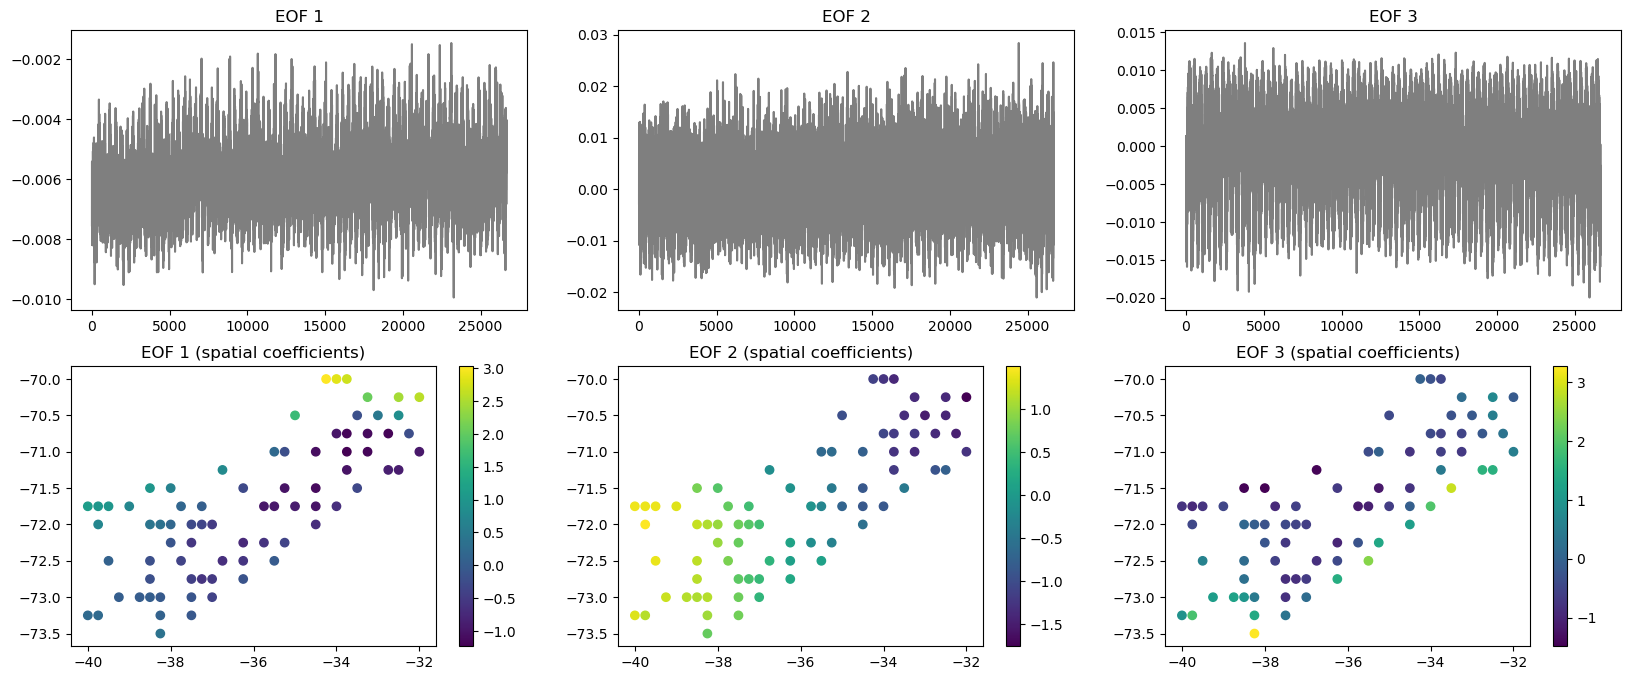

In [5]:
plt.figure(figsize=(20,8))
plt.subplot(2,3,1)
plt.plot(np.arange(len(v[:,0])), v[:,0], color='black', alpha=0.5)
plt.title('EOF 1')
plt.subplot(2,3,2)
plt.plot(np.arange(len(v[:,1])), v[:,1], color='black', alpha=0.5)
plt.title('EOF 2')
plt.subplot(2,3,3)
plt.plot(np.arange(len(v[:,2])), v[:,2], color='black', alpha=0.5)
plt.title('EOF 3')


plt.subplot(2,3,4)
plt.scatter(X_train['latitude'], X_train['longitude'],c=u[:,0])
plt.colorbar()
plt.title('EOF 1 (spatial coefficients)')
plt.subplot(2,3,5)
plt.scatter(X_train['latitude'], X_train['longitude'],c=u[:,1])
plt.colorbar()
plt.title('EOF 2 (spatial coefficients)')
plt.subplot(2,3,6)
plt.scatter(X_train['latitude'], X_train['longitude'],c=u[:,2])
plt.colorbar()
plt.title('EOF 3 (spatial coefficients)')

Vizualizamos el porcentaje de varianza explicada y en que componente se supera el 95%.

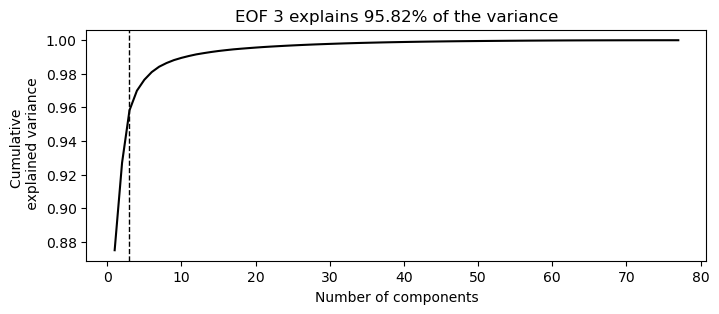

In [6]:
# Calculate the cumulative explained variance
explained_variance_ratio = np.cumsum(tf.math.square(s)/tf.reduce_sum(tf.math.square(s)))

# Find the component that explains more than 95% of the variance
index_95 = np.argmax(explained_variance_ratio > 0.95)

# Total number of EOFs
total_eofs = len(s)

# Plot the scree plot
plt.figure(figsize=(8,3))
plt.plot(np.arange(1, total_eofs+1), explained_variance_ratio, c='black')
plt.axvline(index_95+1, color='black', linestyle='--', linewidth=1)  # +1 because of 0-based indexing
plt.ylabel('Cumulative \n explained variance')
plt.xlabel('Number of components')
plt.title(f'EOF {index_95+1} explains {explained_variance_ratio[index_95]*100:.2f}% of the variance')
plt.savefig('Simulated_screeplot_noise.pdf', dpi=300)
plt.show()


Para comprobar si descomponemos correctamente los datos, podemos reconstruir la señal original y comprobar si obtenemos los mismos valores que en el conjunto de datos original.

In [7]:
# To recompose 
tf_Z_approx = tf.matmul((u/tf.sqrt(nS-1)), tf.matmul(tf.linalg.diag(s), v, adjoint_b=True))

print('Matrix Zt, reconstructed: \n{}\n'.format(tf_Z_approx))

reconstructed = tf_Z_approx * tf.sqrt(nS-1) + time_mean

check = reconstructed - Z
print('True - reconstructed data: \n{}\n'.format(check))

Matrix Zt, reconstructed: 
[[ 0.7765598   0.44066864  0.5773149  ...  0.48446447  0.3058196
   0.21571688]
 [-0.05654908  0.31849894  0.44837403 ...  0.158551    0.4802971
   0.77770394]
 [ 0.04544306 -0.08376763 -0.15949045 ... -0.14982009 -0.27574557
  -0.5499105 ]
 ...
 [ 0.17983702  0.5698208   0.58979744 ...  0.23248449  0.49335173
   0.38183594]
 [-1.1378824  -1.2427493  -1.2722524  ... -0.8704799  -1.0970551
  -0.89479405]
 [ 0.294106    0.6132514   0.6361749  ...  0.32191446  0.5925729
   0.34410605]]

True - reconstructed data: 
[[ 1.02996826e-04 -9.34600830e-05 -4.57763672e-05 ... -5.72204590e-06
  -9.53674316e-06 -5.72204590e-06]
 [-4.57763672e-05  1.14440918e-05 -1.14440918e-05 ... -5.72204590e-06
  -5.72204590e-06 -7.62939453e-06]
 [-5.91278076e-05 -3.05175781e-05  3.81469727e-06 ...  1.90734863e-06
   0.00000000e+00  0.00000000e+00]
 ...
 [ 1.12533569e-04  3.62396240e-05  9.53674316e-06 ...  0.00000000e+00
   1.90734863e-06  3.81469727e-06]
 [-6.52313232e-04 -1.01089478e-

## Modelado de los mapas de coeficientes y reconstrucción del campo espaciotemporal completo
Modelaremos los coeficientes utilizando una red neuronal profunda completamente conectada y de avance directo. La latitud y la longitud se utilizan como entradas para una red neuronal que tiene una primera capa de salida auxiliar donde se modelan los coeficientes espaciales. Una capa de recomposición utilizará entonces los coeficientes modelados y las bases temporales resultantes de la descomposición EOF para reconstruir la salida final, es decir, el campo espaciotemporal.

La red descrita tiene múltiples entradas, a saber, las covariables espaciales, que fluyen a través de la totalidad de capas, y las bases temporales conectadas directamente a la capa de salida. También tiene múltiples salidas, a saber, los coeficientes espaciales para cada base, todos modelados conjuntamente, y la señal de salida. Aunque la red se entrena minimizando la función de pérdida en la salida final, tener como salida auxiliar los mapas de coeficientes espaciales asegura una mejor explicabilidad del modelo, lo cual es de primordial importancia en las ciencias de la tierra y el clima.

In [8]:
from sklearn.preprocessing import StandardScaler

n_eofs = 77

# Si X_train es un DataFrame, lo convertimos a numpy array
if isinstance(X_train, pd.DataFrame):
    X_train = X_train.values

# Dividimos X_train en subconjuntos de entrenamiento y validación
X_train, X_valid = X_train[:53, :], X_train[53:, :]

# Si 'u' es un DataFrame o EagerTensor, lo convertimos a numpy array
if isinstance(u, (pd.DataFrame, tf.Tensor)):
    u = u.numpy() if isinstance(u, tf.Tensor) else u.values

# Dividimos 'u' en subconjuntos de entrenamiento y validación
u_train, u_valid = u[:53, :n_eofs], u[53:, :n_eofs]

# Si 's' es un DataFrame o EagerTensor, lo convertimos a numpy array
if isinstance(s, (pd.DataFrame, tf.Tensor)):
    s = s.numpy() if isinstance(s, tf.Tensor) else s.values

# Nos aseguramos de que 's' tenga el tamaño correcto
s = s[:n_eofs]

# Si 'v' es un DataFrame o EagerTensor, lo convertimos a numpy array
if isinstance(v, (pd.DataFrame, tf.Tensor)):
    v = v.numpy() if isinstance(v, tf.Tensor) else v.values

# Nos aseguramos de que 'v' tenga el tamaño correcto
v = v[:, :n_eofs]

# Instanciamos y ajustamos un StandardScaler para normalizar los datos de entrada
scaler = StandardScaler()
scaler.fit(X_train)

# Escalamos los subconjuntos de entrenamiento, prueba y validación
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_valid = scaler.transform(X_valid)

C:\Users\alezavala\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [9]:
def recompose(x):
    U = tf.cast(x, dtype=tf.float32)
    U = U/tf.sqrt(nS-1)
    test_mean = tf.reshape(time_mean[0,:], [1, time_mean[0,:].shape[0]])
    y_hat = (tf.matmul(U, tf.matmul(tf.linalg.diag(s), v, adjoint_b=True))) *  tf.sqrt(nS-1) + test_mean
    return y_hat

input_A = keras.layers.Input(shape=[2,]) # The input are the geographical variables X, Y, Z
batch1 = keras.layers.BatchNormalization()(input_A)
hidden_1 = keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal")(batch1)
batch2 = keras.layers.BatchNormalization()(hidden_1)
hidden_2 = keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal")(batch2)
batch3 = keras.layers.BatchNormalization()(hidden_2)
hidden_3 = keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal")(batch3)
batch4 = keras.layers.BatchNormalization()(hidden_3)
hidden_4 = keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal")(batch4)
batch5 = keras.layers.BatchNormalization()(hidden_4)
hidden_5 = keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal")(batch5)
batch6 = keras.layers.BatchNormalization()(hidden_5)
aux_output = keras.layers.Dense(n_eofs)(batch6)# Auxiliary output: spatial coefficients u
output = keras.layers.Lambda(recompose)(aux_output) # Main output: reconstructed y




K = keras.backend
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)
batch_size = 32     
n_epochs = 200
patience = 20
onecycle = OneCycleScheduler(len(X_train) // batch_size * n_epochs, max_rate=0.005)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=patience, restore_best_weights = True)

Ahora estamos listos para ejecutar el modelo. El primer modelo que entrenamos modela los 77 componentes.

In [10]:
model = keras.Model(inputs=[input_A], outputs=[output, aux_output])
model.compile(loss=['mae', 'mae'], loss_weights=[1.0,0.0], optimizer="nadam")

history = model.fit([X_train], [y_train.values[:53,:], u_train], epochs=n_epochs,
                    validation_data=([X_valid], [y_train.values[53:,:], u_valid]),
                   callbacks=[onecycle, early_stopping_cb], verbose = 0)

y_hat_test, y_pred_test = model.predict([X_test])

6/6 [==============================] - 0s 3ms/step


Calculamos el MAE como medida de rendimeinto

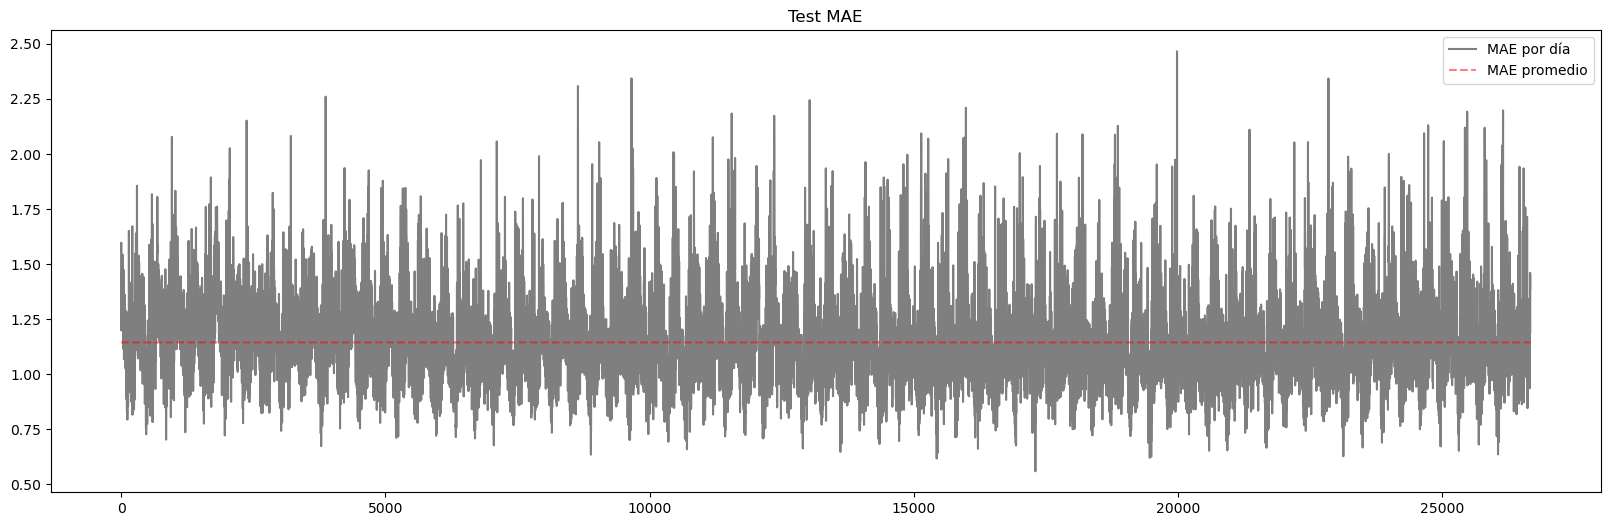

MAE promedio:  1.1447576821010592


In [11]:
# Inicializamos un array de ceros para almacenar los errores absolutos medios (MAE)
mae = np.zeros(y_test.shape[1])

# Iteramos sobre cada columna de y_test (cada día)
for i in range(y_test.shape[1]):
    # Seleccionamos la columna i, reseteamos el índice y descartamos los valores NaN
    y_test_notna = y_test.iloc[:,i].reset_index(drop=True).dropna()
    idx = y_test_notna.index
    # Calculamos el MAE para la columna i, utilizando los índices para alinear y_hat_test con y_test
    mae[i] = MAE(y_test_notna, np.array(y_hat_test)[idx,i])

# Calculamos el MAE promedio para todo el período de prueba
mean_mae = np.mean(mae)

# Crear una figura para el gráfico
plt.figure(figsize=(20,6))
plt.plot(np.arange(len(mae)), mae, c='black', alpha=0.5, label='MAE por día')
plt.plot(np.arange(len(mae)), np.tile(mean_mae, len(mae)), c='red', alpha=0.5, linestyle='--', label='MAE promedio')
plt.legend()
plt.title('Test MAE')
plt.show()

# Imprimir el MAE promedio
print("MAE promedio: ", mean_mae)

Graficamos los mapas escalados.

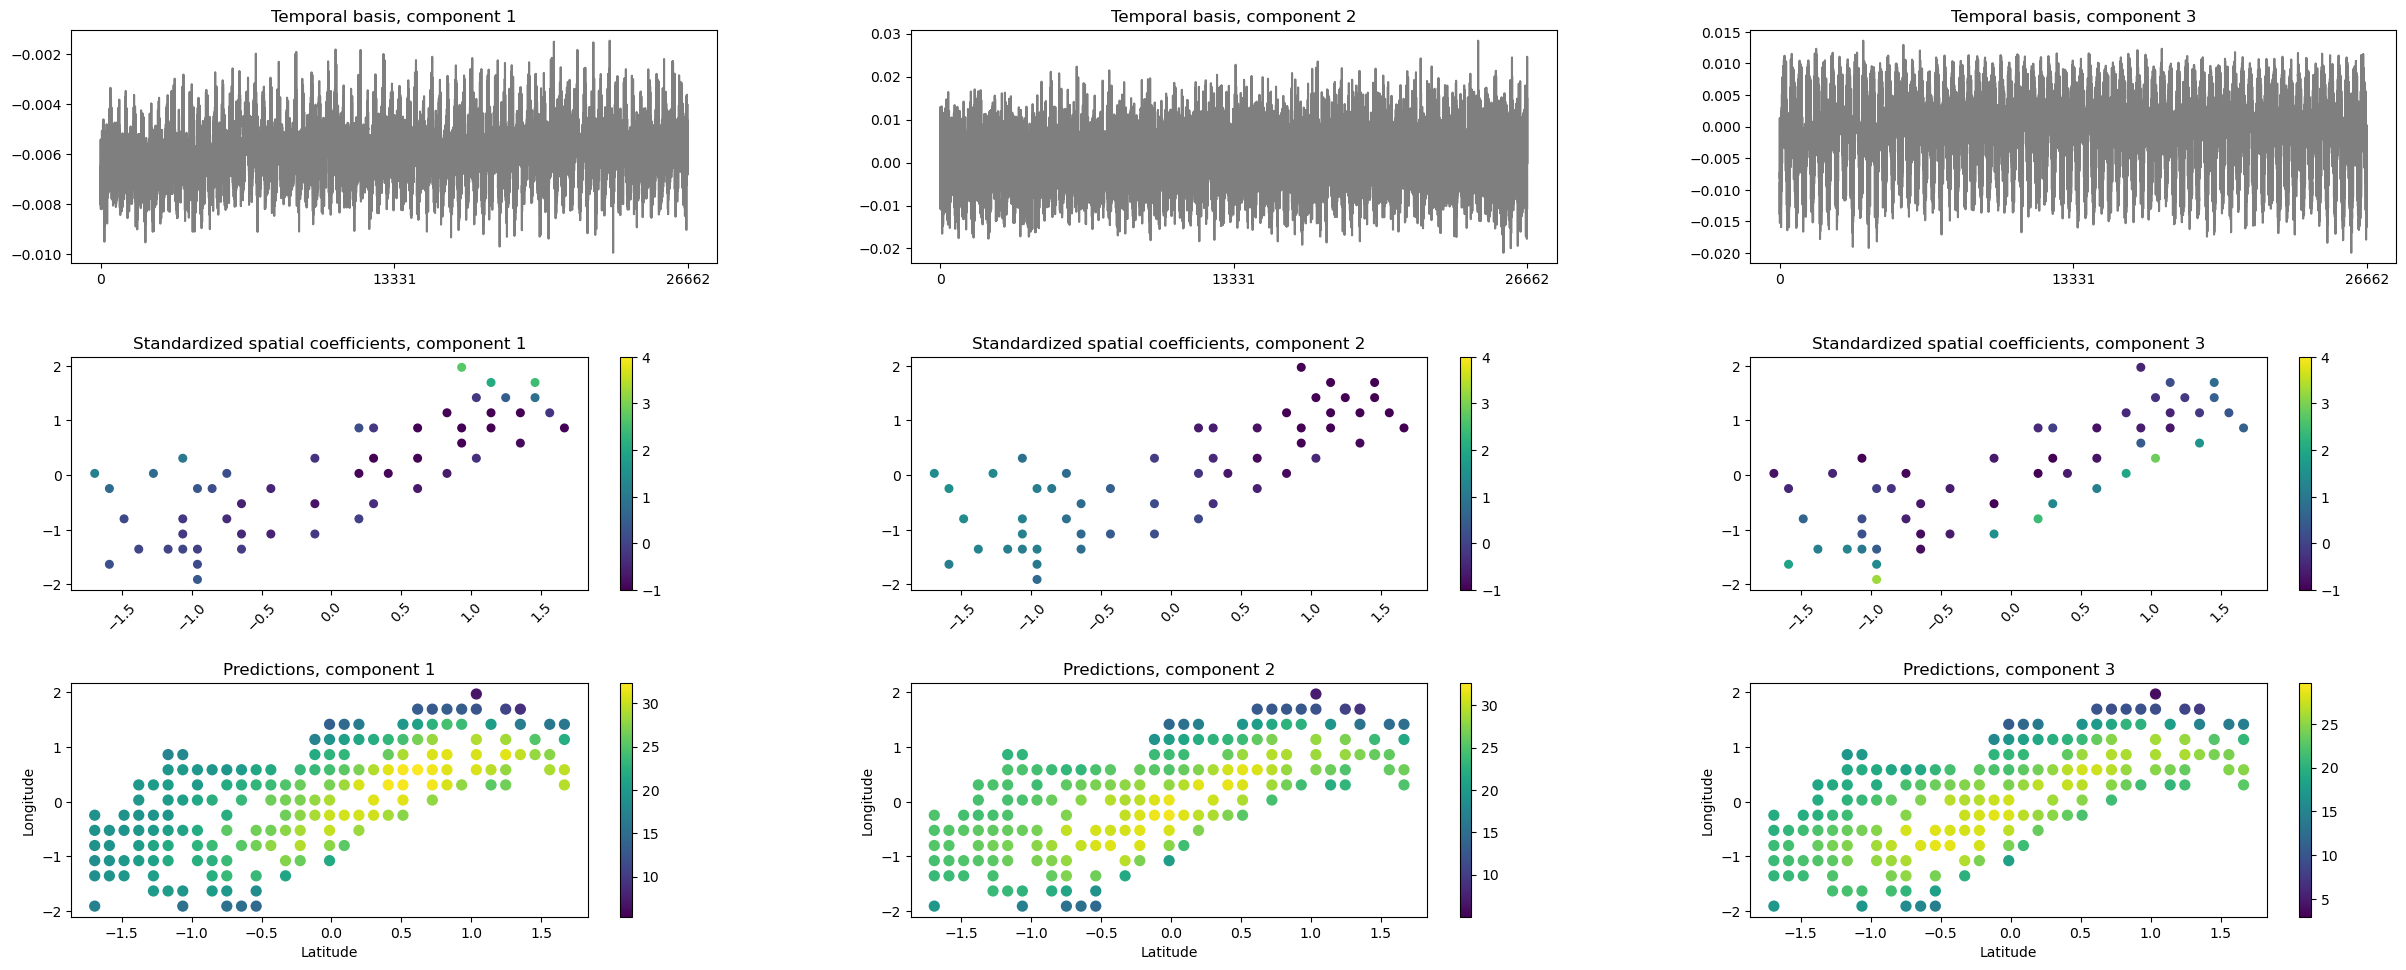

In [12]:
y_train_ = y_train
y_test_ = y_test
X_train_ = X_train
X_test_ = X_test

# Convertimos los datos a un tensor de TensorFlow y realizamos la descomposición en valores singulares (SVD)
Z_ = tf.constant(y_train_.values, dtype=tf.float32)

# Calculamos la media a lo largo del tiempo y la restamos para la detrendación
time_mean_ = tf.reduce_mean(Z_, axis=0)
nS = tf.constant(Z_.shape[0], dtype=tf.float32)
time_mean_ = tf.reshape(tf.tile(time_mean_, [nS]), [nS, time_mean_.shape[0]])

Ztime_detrend_ = Z_ - time_mean_
Ztilde_ = 1/tf.sqrt(nS-1)*Ztime_detrend_
s_, u_, v_ = tf.linalg.svd(Ztilde_)
u_numpy = u_.numpy() * tf.sqrt(nS-1)

# Configurando los índices para los ticks del eje x de acuerdo con y_test_
first_index = 0  # Primer índice
middle_index = len(y_test_.columns) // 2  # Índice del medio
last_index = len(y_test_.columns) - 1  # Último índice
tick_indices = [first_index, middle_index, last_index]
tick_labels = [str(y_test_.columns[i]) for i in tick_indices]

#  X_train_ es un numpy array y las dos primeras columnas son latitud y longitud
latitude = X_train_[:, 0]
longitude = X_train_[:, 1]

# X_test_ es un numpy array y las dos primeras columnas son latitud y longitud para el conjunto de prueba
test_latitude = X_test_[:, 0]
test_longitude = X_test_[:, 1]



plt.figure(figsize=(30, 20))  

# Gráficos de las bases temporales
for i in range(1, 4):
    plt.subplot(5, 3, i)
    plt.plot(np.arange(len(v_[:,i-1])), v_[:,i-1], color='black', alpha=0.5)
    plt.xticks(tick_indices, tick_labels)
    plt.title(f'Temporal basis, component {i}')

# Gráficos de los coeficientes espaciales estandarizados
for i in range(4, 7):
    component_idx = i - 4
    plt.subplot(5, 3, i)
    color_data = u_numpy[:len(latitude), component_idx]
    plt.scatter(latitude, longitude, c=color_data, vmin=-1, vmax=4, s=30)  # Ajusta el tamaño de los puntos con `s`
    plt.xticks(rotation=45)
    plt.colorbar()
    plt.title(f'Standardized spatial coefficients, component {component_idx+1}')

# Gráficos para las predicciones de los tres primeros componentes
for i in range(7, 10):
    component_to_plot = i - 7
    predictions = y_hat_test[:, component_to_plot]
    vmin_val = min(np.min(predictions), np.min(y_test_.iloc[:, component_to_plot]))
    vmax_val = max(np.max(predictions), np.max(y_test_.iloc[:, component_to_plot]))
    plt.subplot(5, 3, i)
    sc = plt.scatter(test_latitude, test_longitude, c=predictions, s=50, vmin=vmin_val, vmax=vmax_val, cmap='viridis')
    plt.colorbar(sc)
    plt.title(f'Predictions, component {component_to_plot+1}')
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')

plt.subplots_adjust(hspace=0.4, wspace=0.3)  
plt.show()

Comparamos los resultados del primer modelo con los reales

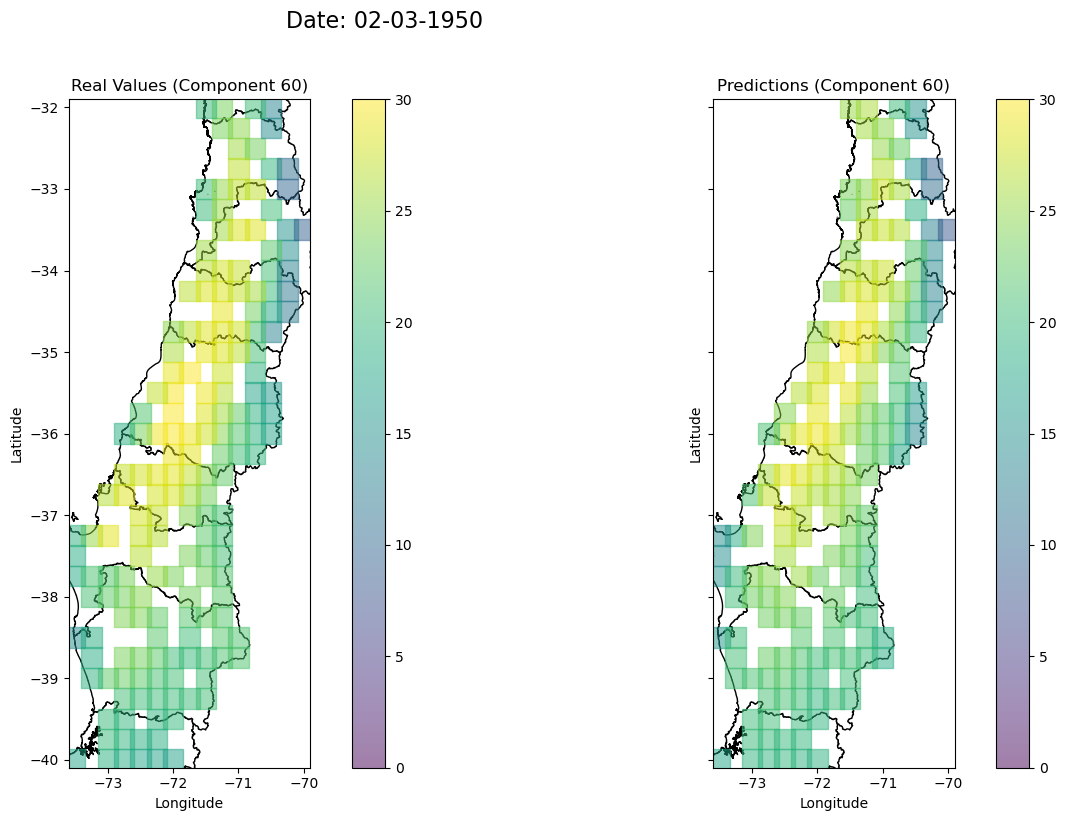

In [13]:
# Función para convertir el número de componente en fecha
def componente_a_fecha(componente, fecha_inicio='1950-01-01'):
    fecha_inicio = datetime.strptime(fecha_inicio, '%Y-%m-%d')
    fecha_componente = fecha_inicio + timedelta(days=componente + 1)
    return fecha_componente.strftime('%d-%m-%Y')

# Configuramos los límites de los colores para la visualización
component_to_plot = 60  # Componente que deseamos visualizar
predictions = y_hat_test[:, component_to_plot]
real_values = y_test_.iloc[:, component_to_plot].values

# Desescalamos los datos de prueba para obtener las coordenadas originales
X_test_descaled = scaler.inverse_transform(X_test)

# Extraemos la latitud y longitud desescaladas
test_latitude_descaled = X_test_descaled[:, 0]
test_longitude_descaled = X_test_descaled[:, 1]

# Configuramos los límites de los colores para la visualización
vmin_val = 0
vmax_val = 30

# Ruta al shapefile de las regiones de Chile
ruta_shapefile = "C:\\Users\\alezavala\\Desktop\\Regiones\\Regional.shp"

# Cargar el shapefile usando geopandas
chile_regiones = gpd.read_file(ruta_shapefile)
chile_regiones = chile_regiones.to_crs(epsg=4326)

# Crear un DataFrame con tus datos desescalados
data = pd.DataFrame({
    'latitude': test_latitude_descaled,
    'longitude': test_longitude_descaled
})

# Crear un GeoDataFrame a partir de tus datos desescalados
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.longitude, data.latitude))
gdf.set_crs(epsg=4326, inplace=True)

# Crear la figura y los ejes para la gráfica con dos subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 8), sharex=True, sharey=True)

# Dibujar el shapefile de las regiones de Chile en ambos subplots
for ax in axs:
    chile_regiones.plot(ax=ax, color='white', edgecolor='black')

# Tamaño de los puntos - Este es un valor que puedes ajustar experimentalmente
size_of_points = 220  # Aumenta o disminuye este valor para que represente visualmente 2500x2500 metros

# Gráfico para los valores reales con ejes desescalados
sc_real = axs[0].scatter(gdf.geometry.x, gdf.geometry.y, c=real_values, s=size_of_points, marker='s', vmin=vmin_val, vmax=vmax_val, cmap='viridis', label='Real Values', alpha=0.5)
axs[0].set_title(f'Real Values (Component {component_to_plot})')
fig.colorbar(sc_real, ax=axs[0])

# Gráfico para las predicciones con ejes desescalados
sc_pred = axs[1].scatter(gdf.geometry.x, gdf.geometry.y, c=predictions, s=size_of_points, marker='s', vmin=vmin_val, vmax=vmax_val, cmap='viridis', label='Predictions', alpha=0.5)
axs[1].set_title(f'Predictions (Component {component_to_plot})')
fig.colorbar(sc_pred, ax=axs[1])

# Añadir etiquetas y título a los ejes
for ax in axs:
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

# Ajustar los límites del eje para enfocar tu área de interés
axs[0].set_xlim(gdf.geometry.x.min() - 0.1, gdf.geometry.x.max() + 0.1)
axs[0].set_ylim(gdf.geometry.y.min() - 0.1, gdf.geometry.y.max() + 0.1)

# Añadir un título general a la figura
fecha_componente = componente_a_fecha(component_to_plot - 1)
plt.suptitle(f'Date: {fecha_componente}', fontsize=16, y=1.02)

plt.tight_layout()
plt.show()

Ahora realizamos un segundo modeloq que manteniendo el 95 % de la variación de los datos.

In [14]:
# Suprimir advertencias específicas de rendimiento de pandas
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

mae_spatial =  np.zeros(y_test.shape[0])
for i in range(y_test.shape[0]):
    y_test_notna = (y_test.iloc[i,:]).reset_index().drop(['time'], axis = 1).dropna()
    idx = y_test_notna.index
    mae_spatial[i] = MAE(y_test_notna.values, np.array(y_hat_test)[i,idx])

n_eofs= 3 
y_train = y_train
y_test = y_test
Z = tf.constant(y_train.values, dtype=tf.float32) 
time_mean = tf.reduce_mean(Z, 0)
nS = tf.constant(Z.shape[0], dtype =tf.float32)
time_mean = tf.reshape(tf.tile(time_mean, [nS]), [nS, time_mean.shape[0]])
Ztime_detrend = Z - time_mean
Ztilde = 1/tf.sqrt(nS-1)*Ztime_detrend
s, u, v = tf.linalg.svd(Ztilde)
u_train, u_valid = u[:53,:n_eofs], u[53:,:n_eofs]
s = s[:n_eofs]
v = v[:,:n_eofs]
# Redefining callbacks
batch_size = 32     
n_epochs = 200
patience = 20
onecycle = OneCycleScheduler(len(X_train) // batch_size * n_epochs, max_rate=0.005)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=patience, restore_best_weights = True) 
# Redefining network structure
input_A = keras.layers.Input(shape=[2,]) # The input are the geographical variables X, Y, Z
batch1 = keras.layers.BatchNormalization()(input_A)
hidden_1 = keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal")(batch1)
batch2 = keras.layers.BatchNormalization()(hidden_1)
hidden_2 = keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal")(batch2)
batch3 = keras.layers.BatchNormalization()(hidden_2)
hidden_3 = keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal")(batch3)
batch4 = keras.layers.BatchNormalization()(hidden_3)
hidden_4 = keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal")(batch4)
batch5 = keras.layers.BatchNormalization()(hidden_4)
hidden_5 = keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal")(batch5)
batch6 = keras.layers.BatchNormalization()(hidden_5)
aux_output = keras.layers.Dense(n_eofs)(batch6)# Auxiliary output: spatial coefficients u
output = keras.layers.Lambda(recompose)(aux_output) # Main output: reconstructed y

model_2 = keras.Model(inputs=[input_A], outputs=[output, aux_output])
# model_2.set_weights(initial_weights)  # restoring initial weights (si es necesario)
model_2.compile(loss=['mae', 'mae'], loss_weights=[1, 0.0], optimizer="nadam")

history_2 = model_2.fit([X_train], [y_train.values[:53,:], u_train], epochs=n_epochs,
                        validation_data=([X_valid], [y_train.values[53:,:], u_valid]),
                        callbacks=[onecycle, early_stopping_cb], verbose=0)

idx = np.argmin(np.asarray(history_2.history[list(history_2.history.keys())[-3]])) 
y_hat_test_, y_pred_test_ = model_2.predict([X_test])

6/6 [==============================] - 0s 2ms/step


In [15]:
X_vis = X.copy()
y_vis =y.copy()
X_vis_scaled = scaler.transform(X_vis)

C:\Users\alezavala\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Utilizamos los modelos entrenados para predecir sobre la malla completa

In [16]:
y_hat_vis, y_pred_vis = model.predict([X_vis_scaled])
y_hat_vis_, y_pred_vis_ = model_2.predict([X_vis_scaled])

9/9 [==============================] - 0s 2ms/step


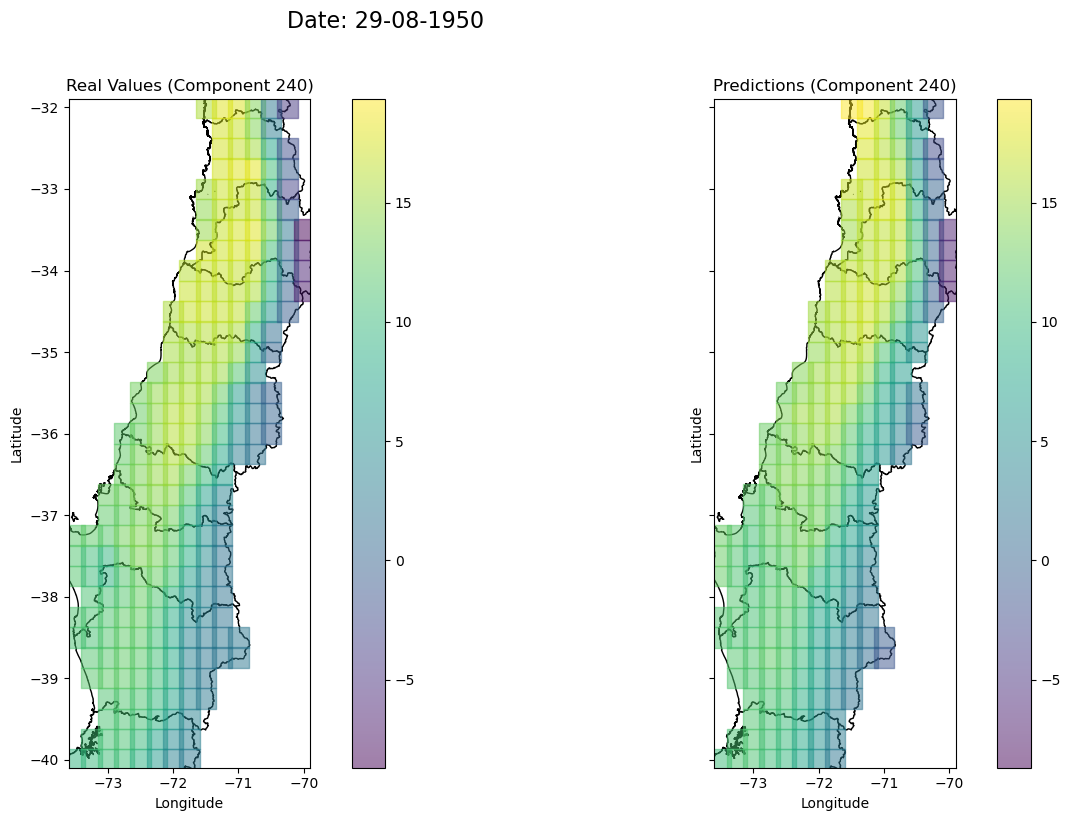

In [17]:
# Seleccionamos la componente específica para la visualización y obtenemos las predicciones
component_to_plot = 240  # Cambia este número para la componente que desees visualizar
predictions = y_hat_vis[:, component_to_plot]

# Obtenemos los valores reales de y_vis para la componente elegida
real_values = y_vis.iloc[:, component_to_plot].values

# Desescalamos los datos de prueba para obtener las coordenadas originales
X_test_descaled = scaler.inverse_transform(X_vis_scaled)

# Extraemos la latitud y longitud desescaladas
test_latitude_descaled = X_test_descaled[:, 0]
test_longitude_descaled = X_test_descaled[:, 1]

# Configuramos los límites de los colores para la visualización
vmin_val = min(real_values.min(), predictions.min())
vmax_val = max(real_values.max(), predictions.max())

# Ruta al shapefile de las regiones de Chile
ruta_shapefile = "C:\\Users\\alezavala\\Desktop\\Regiones\\Regional.shp"

# Cargar el shapefile usando geopandas
chile_regiones = gpd.read_file(ruta_shapefile)
chile_regiones = chile_regiones.to_crs(epsg=4326)

# Crear un DataFrame con tus datos desescalados
data = pd.DataFrame({
    'latitude': test_latitude_descaled,
    'longitude': test_longitude_descaled
})

# Crear un GeoDataFrame a partir de tus datos desescalados
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.longitude, data.latitude))
gdf.set_crs(epsg=4326, inplace=True)

# Crear la figura y los ejes para la gráfica con dos subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 8), sharex=True, sharey=True)

# Dibujar el shapefile de las regiones de Chile en ambos subplots
for ax in axs:
    chile_regiones.plot(ax=ax, color='white', edgecolor='black')

# Tamaño de los puntos - Este es un valor que puedes ajustar experimentalmente
size_of_points = 220  # Aumenta o disminuye este valor para que represente visualmente 2500x2500 metros

# Gráfico para los valores reales con ejes desescalados
sc_real = axs[0].scatter(gdf.geometry.x, gdf.geometry.y, c=real_values, s=size_of_points, marker='s', vmin=vmin_val, vmax=vmax_val, cmap='viridis', label='Real Values', alpha=0.5)
axs[0].set_title(f'Real Values (Component {component_to_plot})')
fig.colorbar(sc_real, ax=axs[0])

# Gráfico para las predicciones con ejes desescalados
sc_pred = axs[1].scatter(gdf.geometry.x, gdf.geometry.y, c=predictions, s=size_of_points, marker='s', vmin=vmin_val, vmax=vmax_val, cmap='viridis', label='Predictions', alpha=0.5)
axs[1].set_title(f'Predictions (Component {component_to_plot})')
fig.colorbar(sc_pred, ax=axs[1])

# Añadir etiquetas y título a los ejes
for ax in axs:
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

# Ajustar los límites del eje para enfocar tu área de interés
axs[0].set_xlim(gdf.geometry.x.min() - 0.1, gdf.geometry.x.max() + 0.1)
axs[0].set_ylim(gdf.geometry.y.min() - 0.1, gdf.geometry.y.max() + 0.1)

# Añadir un título general a la figura con la fecha correspondiente
fecha_componente = componente_a_fecha(component_to_plot - 1)
plt.suptitle(f'Date: {fecha_componente}', fontsize=16, y=1.02)

plt.tight_layout()
plt.show()

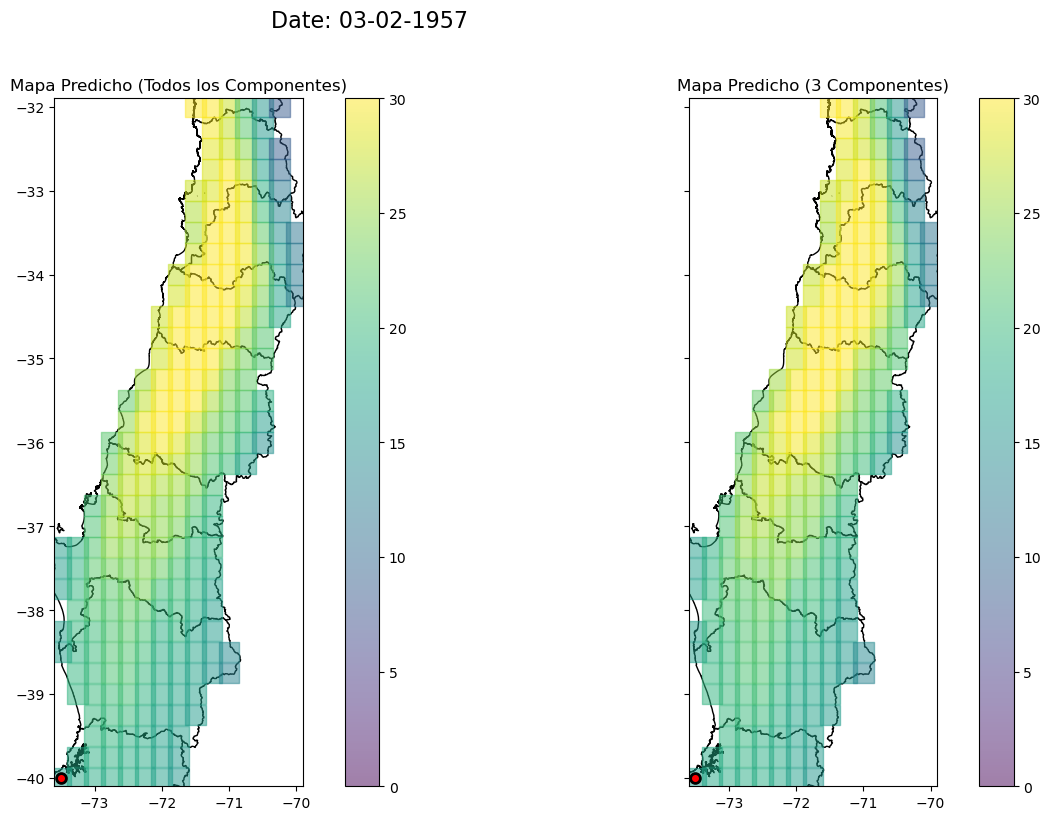

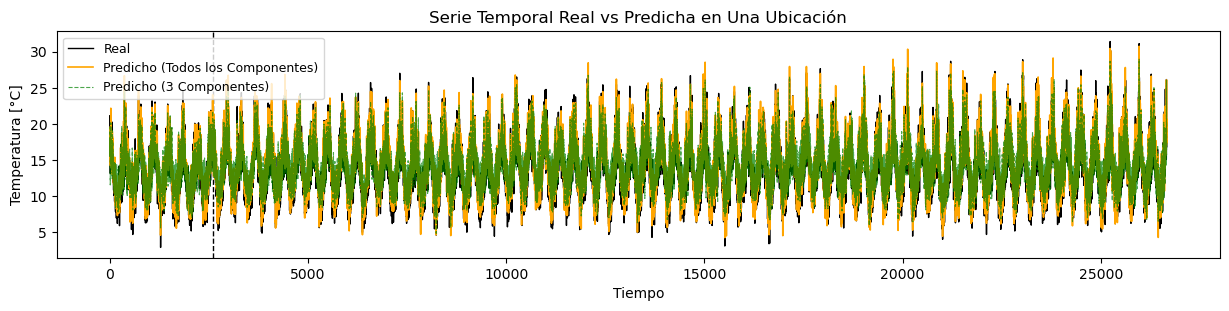

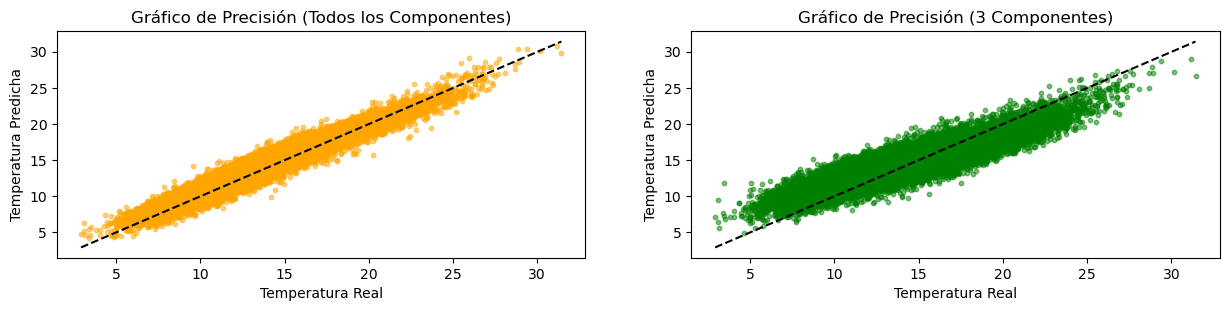

<Figure size 640x480 with 0 Axes>

In [18]:
# Establecer semilla aleatoria para reproducibilidad
np.random.seed(seed=0)

# Seleccionar índices aleatoriamente para la visualización
idx = 2590 #día
idx2 = 0  # Estación

# Extraer latitud y longitud desescaladas
latitude_descaled = X_test_descaled[:, 0]
longitude_descaled = X_test_descaled[:, 1]

# Obtener coordenadas desescaladas para el punto rojo
coords = X_vis.iloc[idx2]
# Cargar shapefile para el contexto geográfico
chile_regiones = gpd.read_file(ruta_shapefile).to_crs(epsg=4326)

# Crear GeoDataFrame para los puntos
gdf = gpd.GeoDataFrame(
    {'latitude': latitude_descaled, 'longitude': longitude_descaled},
    geometry=gpd.points_from_xy(longitude_descaled, latitude_descaled)
)
gdf.set_crs(epsg=4326, inplace=True)

# Configurar los límites de los colores para la visualización
vmin_val = 0
vmax_val = 30

# Crear la figura para mapas
fig_mapas, axs_mapas = plt.subplots(1, 2, figsize=(15, 8), sharex=True, sharey=True)

# Tamaño de los puntos - Este es un valor que puedes ajustar experimentalmente
size_of_points = 220  # Ajusta este valor según tus necesidades

# Gráfico de temperaturas predichas usando todos los componentes
chile_regiones.plot(ax=axs_mapas[0], color='white', edgecolor='black')
sc_all = axs_mapas[0].scatter(gdf.geometry.x, gdf.geometry.y, c=y_hat_vis[:, idx], s=size_of_points, marker='s', vmin=vmin_val, vmax=vmax_val, cmap='viridis', alpha=0.5)
axs_mapas[0].scatter(coords[1], coords[0], c='red', marker='o', s=50, edgecolor='black', linewidth=2, zorder=5)  # Punto destacado
axs_mapas[0].set_title('Mapa Predicho (Todos los Componentes)')
fig_mapas.colorbar(sc_all, ax=axs_mapas[0])

# Gráfico de temperaturas predichas usando 3 componentes
chile_regiones.plot(ax=axs_mapas[1], color='white', edgecolor='black')
sc_6 = axs_mapas[1].scatter(gdf.geometry.x, gdf.geometry.y, c=y_hat_vis[:, idx], s=size_of_points, marker='s', vmin=vmin_val, vmax=vmax_val, cmap='viridis', alpha=0.5)
axs_mapas[1].scatter(coords[1], coords[0], c='red', marker='o', s=50, edgecolor='black', linewidth=2, zorder=5)  # Punto destacado
axs_mapas[1].set_title('Mapa Predicho (3 Componentes)')
fig_mapas.colorbar(sc_6, ax=axs_mapas[1])

# Añadir un título general a la figura con la fecha correspondiente
fecha_componente = componente_a_fecha(idx - 1)
plt.suptitle(f'Date: {fecha_componente}', fontsize=16, y=1.02)

# Ajustar los límites del eje para enfocar tu área de interés
axs_mapas[0].set_xlim(gdf.geometry.x.min() - 0.1, gdf.geometry.x.max() + 0.1)
axs_mapas[0].set_ylim(gdf.geometry.y.min() - 0.1, gdf.geometry.y.max() + 0.1)

plt.tight_layout()
plt.show()

# Gráfico de series temporales verdaderas vs predichas para una ubicación
plt.figure(figsize=(15, 10))  # Ajusta el tamaño según sea necesario
plt.subplot(3, 2, (3, 4))
plt.axvline(x=idx, color='black', linestyle='--', linewidth=1)
plt.plot(np.arange(y_hat_vis.shape[1]), y_vis.iloc[idx2, :], label='Real', color='black', linewidth=1)
plt.plot(np.arange(y_hat_vis.shape[1]), y_hat_vis[idx2, :], label='Predicho (Todos los Componentes)', color='orange', linewidth=1.2)
plt.plot(np.arange(y_hat_vis.shape[1]), y_hat_vis_[idx2, :], label='Predicho (3 Componentes)', color='green', linewidth=0.8, alpha=0.7, linestyle='--')
plt.title('Serie Temporal Real vs Predicha en Una Ubicación')
plt.ylabel('Temperatura [°C]')
plt.xlabel('Tiempo')
plt.legend(loc='best', fontsize=9)
plt.show()

# Gráficos de dispersión de precisión para todos los componentes
plt.figure(figsize=(15, 10))  # Ajusta el tamaño según sea necesario

plt.subplot(3, 2, 5)
plt.scatter(y_vis.iloc[idx2, :], y_hat_vis[idx2, :], label='Real vs Predicho (Todos los Componentes)', color='orange', alpha=0.5, s=10)
plt.plot([y_vis.iloc[idx2, :].min(), y_vis.iloc[idx2, :].max()], [y_vis.iloc[idx2, :].min(), y_vis.iloc[idx2, :].max()], linestyle='--', color='black')
plt.xlabel('Temperatura Real')
plt.ylabel('Temperatura Predicha')
plt.title('Gráfico de Precisión (Todos los Componentes)')

# Gráficos de dispersión de precisión para 3 componentes
plt.subplot(3, 2, 6)
plt.scatter(y_vis.iloc[idx2, :], y_hat_vis_[idx2, :], label='Real vs Predicho (3 Componentes)', color='green', alpha=0.5, s=10)
plt.plot([y_vis.iloc[idx2, :].min(), y_vis.iloc[idx2, :].max()], [y_vis.iloc[idx2, :].min(), y_vis.iloc[idx2, :].max()], linestyle='--', color='black')
plt.xlabel('Temperatura Real')
plt.ylabel('Temperatura Predicha')
plt.title('Gráfico de Precisión (3 Componentes)')

plt.show()

plt.tight_layout()
plt.show()

In [19]:
def control_stats(y_train, y_hat_test, time_mean, X_test, s, v, nS, n_eofs):
    '''
    Adapted function to compute 'control stats' of the prediction.
    -------------------------------------------------------------
    Parameters: 
    - y_train: DataFrame of shape = [n_samples, timestamps]
      The training output samples.
    - y_hat_test: array-like of shape = [n_samples, timestamps]
      The predicted output samples using all components.
    - time_mean: array-like of shape = [n_samples]
      The temporal mean subtracted from data.
    - X_test: DataFrame or array-like of shape = [n_samples, n_features]
      The test input samples.
    - s: array-like of shape = [n_eofs]
      The singular values from decomposition.
    - v: array-like of shape = [timesteps, n_eofs]
      The principal components timeseries from decomposition.
    - nS: int
      The number of training samples.
    - n_eofs: int
      The number of EOFs to be considered.
    '''
    prediction_range = y_train.shape[1]
    y_mean = np.zeros(prediction_range)
    y_var = np.zeros(prediction_range)
    y_min = np.zeros(prediction_range)
    y_max = np.zeros(prediction_range)
    test_mean = np.zeros(prediction_range)
    test_var = np.zeros(prediction_range)
    test_min = np.zeros(prediction_range)
    test_max = np.zeros(prediction_range)

    # Calculate statistics for each timestamp
    for t in range(prediction_range):
        y_mean[t] = y_train.iloc[:, t].mean()
        y_var[t] = y_train.iloc[:, t].var()
        y_min[t] = y_train.iloc[:, t].min()
        y_max[t] = y_train.iloc[:, t].max()
        test_mean[t] = y_hat_test[:, t].mean()
        test_var[t] = y_hat_test[:, t].var()
        test_min[t] = y_hat_test[:, t].min()
        test_max[t] = y_hat_test[:, t].max()

    # Combine statistics into a DataFrame
    stats = pd.DataFrame({
        'y_mean': y_mean,
        'y_var': y_var,
        'y_min': y_min,
        'y_max': y_max,
        'test_mean': test_mean,
        'test_var': test_var,
        'test_min': test_min,
        'test_max': test_max
    })

    return stats


n_eofs = 77  # Para todos los componentes
nS = y_train.shape[0]  # Suponiendo que esta es la cantidad de muestras de entrenamiento
stats_all = control_stats(y_train, y_hat_test, time_mean, X_test, s, v, nS, n_eofs)

n_eofs = 3  # Para 3 componentes
stats_15 = control_stats(y_train, y_hat_test_, time_mean, X_test, s, v, nS, n_eofs)

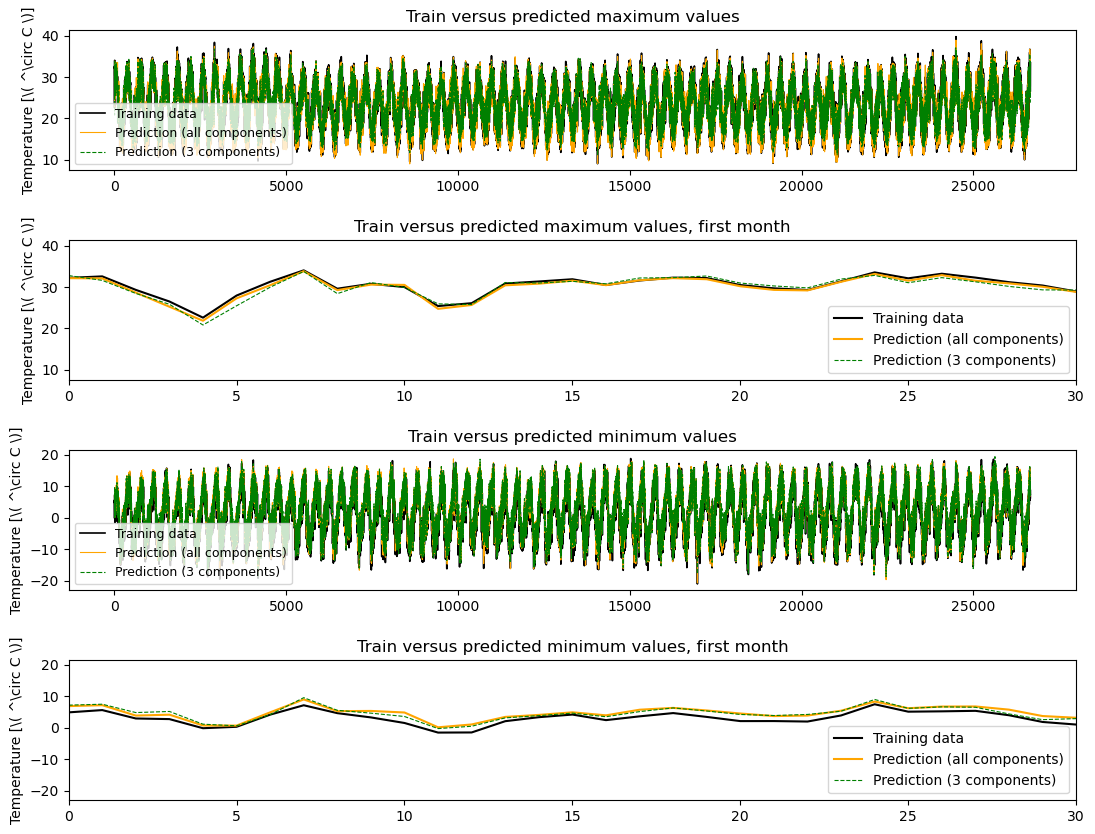

In [20]:
# Configurar el tamaño de la figura y el espacio entre subplots
plt.figure(figsize=(13,10))
plt.subplots_adjust(hspace = 0.5)

# Plot máximo - todos los datos
plt.subplot(4,1,1)
stats_all['y_max'].plot(label='Training data', color='black', linewidth=1.2)
stats_all['test_max'].plot(label='Prediction (all components)', color='orange', linewidth=0.8)
stats_15['test_max'].plot(label='Prediction (3 components)', color='green', linewidth=0.8, alpha=1, linestyle='--')
plt.title('Train versus predicted maximum values')
plt.ylabel('Temperature [\( ^\circ C \)]')
plt.legend(loc=3, fontsize=9)

# Plot máximo - primer mes
plt.subplot(4,1,2)
stats_all['y_max'].plot(label='Training data', color='black')
stats_all['test_max'].plot(label='Prediction (all components)', color='orange')
stats_15['test_max'].plot(label='Prediction (3 components)', color='green', linewidth=0.8, alpha=1, linestyle='--')
plt.xlim((0,30))  
plt.title('Train versus predicted maximum values, first month')
plt.ylabel('Temperature [\( ^\circ C \)]')
plt.legend()

# Plot mínimo - todos los datos
plt.subplot(4,1,3)
stats_all['y_min'].plot(label='Training data', color='black', linewidth=1.2)
stats_all['test_min'].plot(label='Prediction (all components)', color='orange', linewidth=0.8)
stats_15['test_min'].plot(label='Prediction (3 components)', color='green', linewidth=0.8, alpha=1, linestyle='--')
plt.title('Train versus predicted minimum values')
plt.ylabel('Temperature [\( ^\circ C \)]')
plt.legend(loc=3, fontsize=9)

# Plot mínimo - primer mes
plt.subplot(4,1,4)
stats_all['y_min'].plot(label='Training data', color='black')
stats_all['test_min'].plot(label='Prediction (all components)', color='orange')
stats_15['test_min'].plot(label='Prediction (3 components)', color='green', linewidth=0.8, alpha=1, linestyle='--')
plt.xlim((0,30))  # Asumiendo que 672 corresponde a la cantidad de datos del primer mes
plt.title('Train versus predicted minimum values, first month')
plt.ylabel('Temperature [\( ^\circ C \)]')
plt.legend()

plt.show()